In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from pandas import json_normalize
from scipy import stats
from scipy.signal import savgol_filter

In [2]:
df = pd.read_csv("C:/Users/user/Desktop/GA4_project/preproccessed_df.csv")

# 시간 단위 컬럼으로 변환
df['utc_time'] = pd.to_datetime(df['utc_time'])

df.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_22776\477848715.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/user/Desktop/GA4_project/preproccessed_df.csv")


,fullVisitorId,visitStartTime,channelGrouping,continent,subContinent,country,city,visits,pageviews,hits,...,bounces,transactionRevenue,campaign,source,medium,keyword,browser,operatingSystem,deviceCategory,utc_time
0,1131660440785968503,1472830385,Organic Search,Asia,Western Asia,Turkey,Izmir,1,1,1,...,1,0,(not set),google,organic,(not provided),Chrome,Windows,desktop,2016-09-02 15:33:05+00:00
1,377306020877927890,1472880147,Organic Search,Oceania,Australasia,Australia,not available in demo dataset,1,1,1,...,1,0,(not set),google,organic,(not provided),Firefox,Macintosh,desktop,2016-09-03 05:22:27+00:00
2,3895546263509774583,1472865386,Organic Search,Europe,Southern Europe,Spain,Madrid,1,1,1,...,1,0,(not set),google,organic,(not provided),Chrome,Windows,desktop,2016-09-03 01:16:26+00:00


## 방문 주차별 리텐션 히트맵 시각화

- 6주간의 리텐션만 히트맵을 만드는 것으로 함
- 기록에 남아있는 기간중 가장 방문율이 높았던 기간 6개월을 사용하기로 함 - WAU 확인

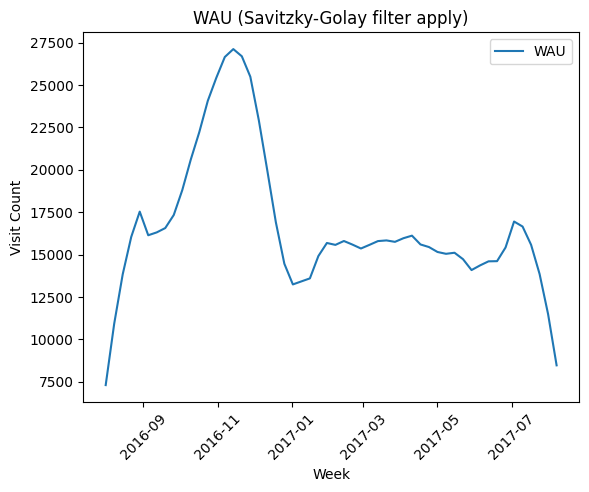

In [3]:
# 'utc_time' 컬럼을 datetime 형식으로 변환
df['utc_time'] = pd.to_datetime(df['utc_time'])

# 'utc_time' 컬럼에서 날짜를 추출하여 새로운 컬럼 추가
df['date'] = df['utc_time'].dt.date

# 주 단위로 데이터 집계
weekly_counts = df.resample('W-Mon', on='utc_time').size()

# Savitzky-Golay 필터 적용
smoothed_weekly_counts = savgol_filter(weekly_counts.values, window_length=10, polyorder=2)

# 선 그래프 그리기
plt.plot(weekly_counts.index, smoothed_weekly_counts, label='WAU')
plt.title('WAU (Savitzky-Golay filter apply)')
plt.xlabel('Week')
plt.ylabel('Visit Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

- WAU를 보면 2016년 11월과 12월이 가장 많은 접속자가 있었던 기간임을 알 수 있음

- 샘플링한 기간 : 2016년 11월 1일 ~ 2016년 12월 13일

1. 2016년 11월 1일부터 2016년 11월 7일까지의 기간

In [28]:
def make_list_return_user_count(df, start_date, end_date):
    # start_date와 end_date를 datetime 형식으로 변환
    start_date = pd.Timestamp(start_date, tz='UTC')
    end_date = pd.Timestamp(end_date, tz='UTC')

    # 해당 기간 동안 접속한 적이 있는 fullVisitorId 추출
    visited_customers_start = df.loc[(df['utc_time'] >= start_date) & (df['utc_time'] <= end_date), 'fullVisitorId'].unique()

    # 다시 접속한 유저 수를 저장할 리스트
    return_users_count = [len(visited_customers_start)]

    # 기간의 끝을 기준으로 6주간의 기간에 대한 반복
    for i in range(1, 6):
        # 다음 주의 시작과 끝 날짜 계산
        next_week_start = end_date + pd.DateOffset(days=1)
        next_week_end = end_date + pd.DateOffset(days=7)

        # 해당 기간 동안 접속한 적이 있는 fullVisitorId 추출
        visited_customers_next_week = df.loc[(df['utc_time'] >= next_week_start) & (df['utc_time'] <= next_week_end), 'fullVisitorId'].unique()

        # 해당 주에 다시 접속한 유저 수를 리스트에 추가
        return_users_count.append(len(set(visited_customers_start) & set(visited_customers_next_week)))

        # 다음 주를 위해 기간 업데이트
        end_date = next_week_end

    # 6주간의 다시 접속한 유저들의 수 리스트 반환
    return return_users_count

# 함수 확인
_2016_11_01_to_2016_11_07 = make_list_return_user_count(df, '2016-11-01', '2016-11-07')

_2016_11_01_to_2016_11_07


[19730, 532, 398, 289, 299, 181]

- 만든 함수를 이용해 각 주로부터 6주간의 리텐션을 담은 리스트 생성

In [31]:
# 11월 1일부터 7일까지
_2016_11_01_to_2016_11_07 = make_list_return_user_count(df, '2016-11-01', '2016-11-07')
print(_2016_11_01_to_2016_11_07)

# 11월 8일 부터 11월 14일까지
_2016_11_08_to_2016_11_14 = make_list_return_user_count(df, '2016-11-08', '2016-11-14')
print(_2016_11_08_to_2016_11_14)

# 11월 15일 부터 11월 21일까지
_2016_11_15_to_2016_11_21 = make_list_return_user_count(df, '2016-11-15', '2016-11-21')
print(_2016_11_15_to_2016_11_21)

# 11월 22일 부터 11월 28일까지
_2016_11_22_to_2016_11_28 = make_list_return_user_count(df, '2016-11-22', '2016-11-28')
print(_2016_11_22_to_2016_11_28)
      
# 11월 29일 부터 12월 5일까지
_2016_11_29_to_2016_12_05 = make_list_return_user_count(df, '2016-11-29', '2016-12-05')
print(_2016_11_29_to_2016_12_05)

# 12월 6일 부터 12월 12일까지
_2016_12_06_to_2016_12_12 = make_list_return_user_count(df, '2016-12-06', '2016-12-12')
print(_2016_12_06_to_2016_12_12)

[19730, 532, 398, 289, 299, 181]
[19869, 611, 347, 389, 212, 142]
[21318, 598, 494, 287, 232, 121]
[20303, 651, 349, 256, 152, 106]
[20958, 647, 362, 201, 152, 175]
[14398, 589, 292, 180, 203, 128]


- 생성한 리스트를 데이터 프레임으로 변환

In [48]:
# 데이터 프레임 생성 (전치하여 생성)
weekly_retention_data = {
    '2016_11_01 ~ 2016_11_07': _2016_11_01_to_2016_11_07,
    '2016_11_08 ~ 2016_11_14': _2016_11_08_to_2016_11_14,
    '2016_11_15 ~ 2016_11_21': _2016_11_15_to_2016_11_21,
    '2016_11_22 ~ 2016_11_28': _2016_11_22_to_2016_11_28,
    '2016_11_29 ~ 2016_12_05': _2016_11_29_to_2016_12_05,
    '2016_12_06 ~ 2016_12_12': _2016_12_06_to_2016_12_12
}

weekly_retention = pd.DataFrame(weekly_retention_data, index=['week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6']).T

# 결과 출력
weekly_retention



,week_1,week_2,week_3,week_4,week_5,week_6
2016_11_01 ~ 2016_11_07,19730,532,398,289,299,181
2016_11_08 ~ 2016_11_14,19869,611,347,389,212,142
2016_11_15 ~ 2016_11_21,21318,598,494,287,232,121
2016_11_22 ~ 2016_11_28,20303,651,349,256,152,106
2016_11_29 ~ 2016_12_05,20958,647,362,201,152,175
2016_12_06 ~ 2016_12_12,14398,589,292,180,203,128


- 히트맵 생성

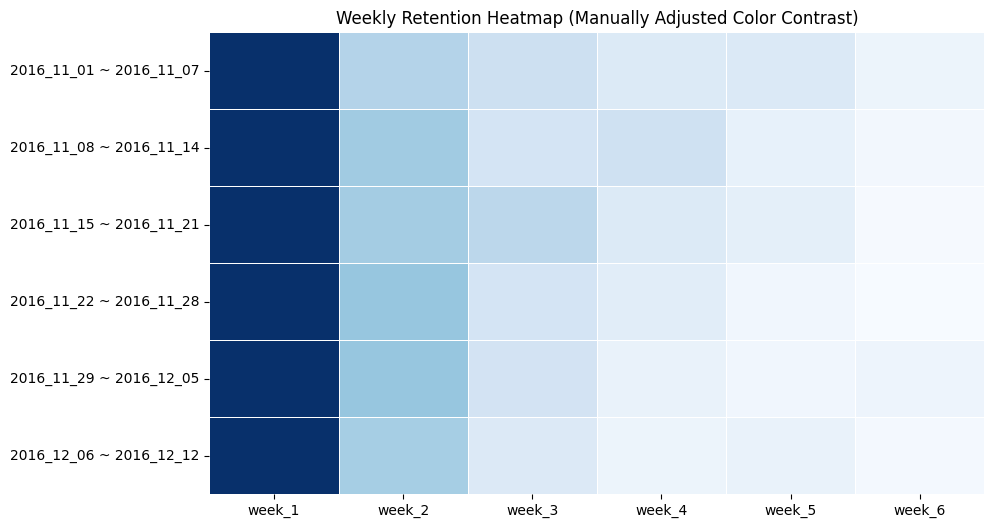

In [64]:
# 히트맵 생성 (Blues 색상 맵 사용)
# 히트맵 생성 (vmin 및 vmax에 숫자 직접 적용)
plt.figure(figsize=(10, 6))
sns.heatmap(weekly_retention, annot=False, cmap='Blues', linewidths=.5, cbar=False, vmin=100, vmax=1500)
plt.title('Weekly Retention Heatmap (Manually Adjusted Color Contrast)')

plt.show()